<a href="https://colab.research.google.com/github/Deleolowo/Assignment/blob/main/Project_2_Data_Cleaning_and_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- 1. IMPORT LIBRARIES ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import gc

In [2]:
# Load metadata
meta_df = pd.read_csv('historical_stocks.csv') # the metadata raw file

print("Missing values BEFORE cleaning:\n")
print(meta_df.isna().sum(), "\n")

# 1. Drop rows with no ticker (ticker is primary key)
meta_df = meta_df.dropna(subset=['ticker'])

# 2. Normalize sector & industry
meta_df['sector'] = meta_df['sector'].str.strip().str.upper()
meta_df['industry'] = meta_df['industry'].str.strip().str.upper()

# 3. Fill missing text values
fill_values = {
    'exchange': 'UNKNOWN',
    'sector': 'UNKNOWN',
    'industry': 'UNKNOWN'
}
meta_df = meta_df.fillna(fill_values)

# 4. Deduplicate tickers
meta_df = meta_df.drop_duplicates(subset='ticker', keep='first')

# 5. Keep only essential cols
meta_df = meta_df[['ticker', 'exchange', 'sector', 'industry']]

print("Missing values AFTER cleaning:\n")
print(meta_df.isna().sum())
print("\nMetadata cleaned successfully!")

gc.collect() # garbage collector - very useful for collecting garbage from colab.

Missing values BEFORE cleaning:

ticker         0
exchange       0
name           0
sector      1440
industry    1440
dtype: int64 

Missing values AFTER cleaning:

ticker      0
exchange    0
sector      0
industry    0
dtype: int64

Metadata cleaned successfully!


65

In [3]:
hist_df = pd.read_csv('historical_stock_prices.csv') # the stock prices raw dataset

# Convert date to datetime
hist_df['date'] = pd.to_datetime(hist_df['date'])

# 1. Sort by ticker + date
hist_df = hist_df.sort_values(['ticker', 'date'])

# 2. Interpolate OHLCV per ticker
def fast_interpolation(group):
    group = group.sort_values('date')
    numeric_cols = ['open','close','adj_close','low','high','volume']
    group[numeric_cols] = (
        group[numeric_cols]
        .interpolate(method='linear')
        .bfill()
        .ffill()
    )
    return group

hist_df_cleaned = hist_df.groupby('ticker', group_keys=False).apply(fast_interpolation)

print("Missing values AFTER interpolation:\n")
print(hist_df_cleaned.isna().sum())
gc.collect()


Missing values AFTER interpolation:

ticker       0
open         0
close        0
adj_close    0
low          0
high         0
volume       0
date         1
dtype: int64


/tmp/ipython-input-85875344.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hist_df_cleaned = hist_df.groupby('ticker', group_keys=False).apply(fast_interpolation)


0

In [4]:
# Merge Dataset to AVOID CRASH!!!

merged_df = hist_df_cleaned.merge(meta_df, on='ticker', how='left') # this syntax merged the both files at this point because they are much samller and minimizes crash.

print("Merged dataset shape:", merged_df.shape)
merged_df.head()
gc.collect()

Merged dataset shape: (1167219, 11)


0

In [5]:
# Save the file to Parquet:

# Note to myself: Parquet is more efficient than CSV. After experiencing many crashes, I switched to using Parquet. It preserves data types—such as categorical, integer, and datetime—unlike CSV, which does not. Parquet is better suited for large datasets and helps reduce memory usage (RAM.

merged_df.to_parquet('/content/merged_df.parquet', compression='snappy')
print("Saved merged_df.parquet!")
gc.collect()

Saved merged_df.parquet!


0

In [6]:
# Download the merged file and save it to avoid data loss

from google.colab import files
files.download('/content/merged_df.parquet')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
#import gc -  this is use to collect the grabage in the system that takes up memory/space (RAM)
gc.collect()

22

In [8]:
# Reload the merged dataset for use in the FE. It holds all of the files in one place ( prices and metadata)

merged_df = pd.read_parquet('/content/merged_df.parquet')
print("Reloaded merged_df shape:", merged_df.shape)

gc.collect()

Reloaded merged_df shape: (1167219, 11)


0

In [9]:
# Feature Engineering (Smooths price movement by averaging over past days — reduces noise.)

# Group by ticker so each stock is processed separately
grp = merged_df.groupby('ticker')['close']

# 7-day Moving Average — short-term trend
merged_df['MA_7'] = grp.transform(lambda x: x.rolling(7).mean())

# 14-day Moving Average — medium-term trend
merged_df['MA_14'] = grp.transform(lambda x: x.rolling(14).mean())

# 21-day Moving Average — long-ish trend
merged_df['MA_21'] = grp.transform(lambda x: x.rolling(21).mean())

gc.collect()
print("Moving averages completed!")

Moving averages completed!


In [10]:
# Rolling Standard Deviations (Volatility) Measures how much the price fluctuates — higher std = higher volatility.

# 7-day volatility
merged_df['std_7'] = grp.transform(lambda x: x.rolling(7).std())

# 14-day volatility
merged_df['std_14'] = grp.transform(lambda x: x.rolling(14).std())

# 30-day volatility (longer-term uncertainty)
merged_df['std_30'] = grp.transform(lambda x: x.rolling(30).std())

gc.collect()
print("STD features completed!")

STD features completed!


In [11]:
# Price Momentum : Measures whether the stock is rising or falling compared to 1 week ago.

# Momentum = today's close - close price 7 days ago
merged_df['Price_Momentum'] = grp.transform(lambda x: x - x.shift(7))

gc.collect()
print("Price Momentum completed!")

Price Momentum completed!


In [12]:
# RSI (Relative Strength Index: 14-day) RSI tells whether a stock is overbought (>70) or oversold (<30). Calculated using avg gains vs avg losses.

# 1. Price change between days
merged_df['delta'] = grp.diff()

# 2. Positive changes (gains)
merged_df['gain'] = merged_df['delta'].clip(lower=0)

# 3. Negative changes (losses)
merged_df['loss'] = -merged_df['delta'].clip(upper=0)

# 4. 14-period rolling average gain
merged_df['avg_gain'] = merged_df.groupby('ticker')['gain'].transform(
    lambda x: x.rolling(14, min_periods=1).mean()
)

# 5. 14-period rolling average loss
merged_df['avg_loss'] = merged_df.groupby('ticker')['loss'].transform(
    lambda x: x.rolling(14, min_periods=1).mean()
)

# 6. RS = avg gain / avg loss
merged_df['RS'] = merged_df['avg_gain'] / merged_df['avg_loss']

# 7. RSI formula
merged_df['RSI14'] = 100 - (100 / (1 + merged_df['RS']))

gc.collect()
print("RSI completed!")

# 8. Drop temporary columns to reduce RAM
merged_df.drop(['delta', 'gain', 'loss', 'avg_gain', 'avg_loss', 'RS'],
               axis=1, inplace=True)

gc.collect()

RSI completed!


0

In [13]:
# MACD and Signal Line: MACD is a widely used trend indicator.
#It compares fast (12-day) and slow (26-day) EMAs.
#Signal line is the 9-day EMA of MACD.

# 12-day Exponential Moving Average (fast)
EMA12 = grp.transform(lambda x: x.ewm(span=12, adjust=False).mean())

# 26-day Exponential Moving Average (slow)
EMA26 = grp.transform(lambda x: x.ewm(span=26, adjust=False).mean())

# MACD = fast EMA - slow EMA
merged_df['MACD'] = EMA12 - EMA26

# MACD Signal = 9-day EMA of MACD
merged_df['MACD_signal'] = merged_df.groupby('ticker')['MACD'].transform(
    lambda x: x.ewm(span=9, adjust=False).mean()
)

# Free memory — no longer needed
del EMA12, EMA26
gc.collect()

print("MACD completed!")

MACD completed!


In [14]:
#Drop metadata columns to reduce size and avoid crashes
cols_to_drop = ['exchange', 'sector', 'industry']

merged_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print("Dropped metadata columns. New shape:", merged_df.shape)

Dropped metadata columns. New shape: (1167219, 18)


In [15]:
# Save FE Dataset to Parquet

# Save this file to Parquet and avoid data loss during this project:

merged_df.to_parquet('/content/merged_df_FE.parquet', compression='snappy')


# Download the file to avoid data loss

files.download('/content/merged_df_FE.parquet')

print("Feature-engineered dataset saved & Downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Feature-engineered dataset saved & Downloaded!


In [16]:
# Ensure correct chronological order
merged_df = merged_df.sort_values(['ticker', 'date']).reset_index(drop=True)

print("Sorted dataset shape:", merged_df.shape)

Sorted dataset shape: (1167219, 18)


In [17]:
# Create Train / Validation / Test Splits

train_size = int(len(merged_df) * 0.70)
val_size = int(len(merged_df) * 0.15)

train_df = merged_df.iloc[:train_size]
val_df = merged_df.iloc[train_size : train_size + val_size]
test_df = merged_df.iloc[train_size + val_size :]

print("Train:", train_df.shape)
print("Validation:", val_df.shape)
print("Test:", test_df.shape)


Train: (817053, 18)
Validation: (175082, 18)
Test: (175084, 18)


In [18]:
# Save the Train/Val/Test Dataset

# Save the train/val/test datasets to Parquet files
train_df.to_parquet('/content/train_df.parquet', compression='snappy')
val_df.to_parquet('/content/val_df.parquet', compression='snappy')
test_df.to_parquet('/content/test_df.parquet', compression='snappy')

# Download each file
files.download('/content/train_df.parquet')
files.download('/content/val_df.parquet')
files.download('/content/test_df.parquet')

print("All splits saved & Downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All splits saved & Downloaded!


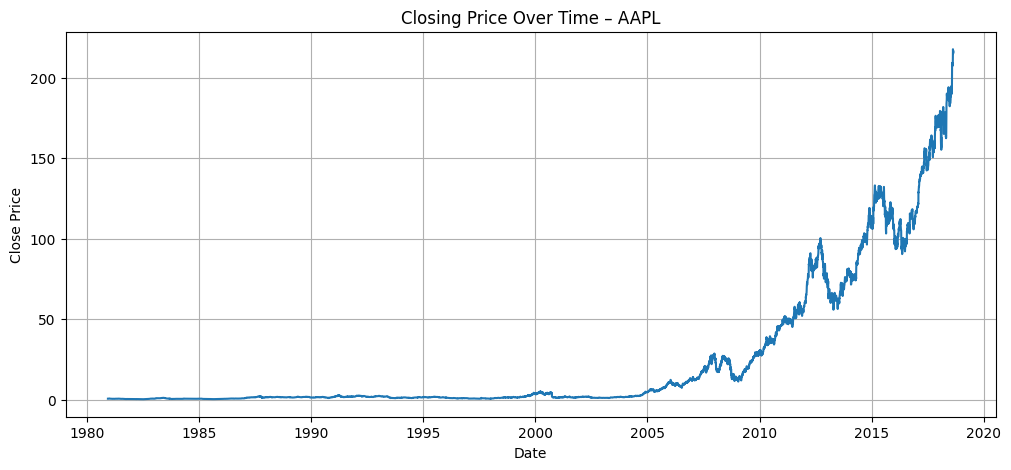

In [19]:
#Closing Price Over Time (Per Ticker)

import matplotlib.pyplot as plt

# Select a sample ticker
sample_ticker = merged_df['ticker'].unique()[0]

df_sample = merged_df[merged_df['ticker'] == sample_ticker]

plt.figure(figsize=(12,5))
plt.plot(df_sample['date'], df_sample['close'])
plt.title(f"Closing Price Over Time – {sample_ticker}")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

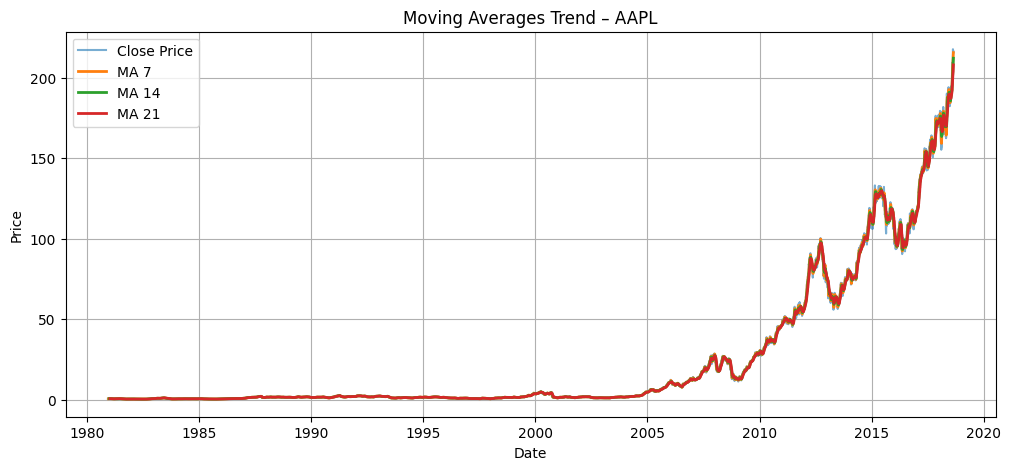

In [20]:
# Moving Averages Overlay Chart (Trend Detection)

plt.figure(figsize=(12,5))
plt.plot(df_sample['date'], df_sample['close'], label='Close Price', alpha=0.6)
plt.plot(df_sample['date'], df_sample['MA_7'], label='MA 7', linewidth=2)
plt.plot(df_sample['date'], df_sample['MA_14'], label='MA 14', linewidth=2)
plt.plot(df_sample['date'], df_sample['MA_21'], label='MA 21', linewidth=2)

plt.title(f"Moving Averages Trend – {sample_ticker}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

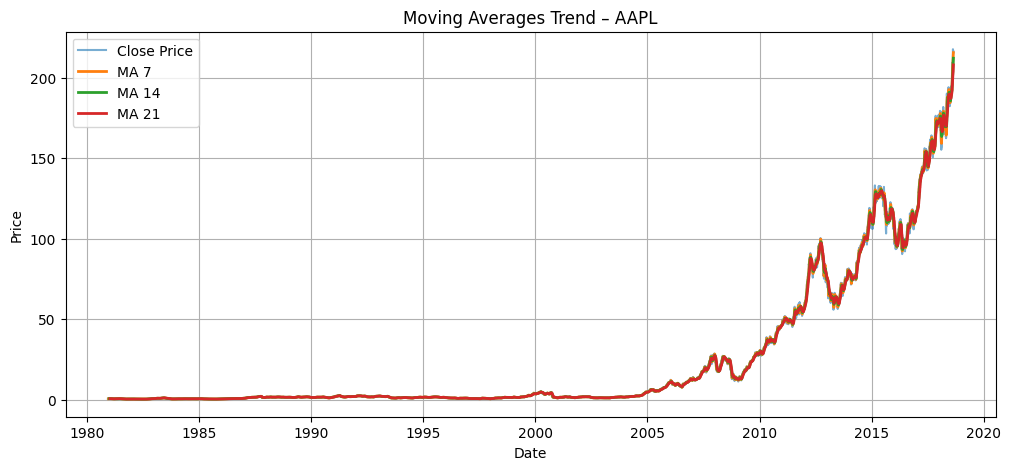

In [21]:
# Moving Averages Overlay Chart (Trend Detection)

plt.figure(figsize=(12,5))
plt.plot(df_sample['date'], df_sample['close'], label='Close Price', alpha=0.6)
plt.plot(df_sample['date'], df_sample['MA_7'], label='MA 7', linewidth=2)
plt.plot(df_sample['date'], df_sample['MA_14'], label='MA 14', linewidth=2)
plt.plot(df_sample['date'], df_sample['MA_21'], label='MA 21', linewidth=2)

plt.title(f"Moving Averages Trend – {sample_ticker}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
